# Estudo dos dados do Censo Escolar 2019

### Análise e Agrupamento de Escolas com K-Means

**K-Means** é um método de Clustering que objetiva particionar n observações dentre k grupos onde cada observação pertence ao grupo mais próximo da média. Isso resulta em uma divisão do espaço de dados em um Diagrama de Voronoi. ([Fonte](https://pt.wikipedia.org/wiki/K-means))


In [0]:
# Importando Bibliotecas.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
import warnings
import os

# Carregamento e Análise iniciais dos Dados

In [3]:
# Análise dos Dados
# Carregando a base de dados (Fonte: http://download.inep.gov.br/microdados/microdados_educacao_basica_2019.zip - Arquivo: ESCOLAS.CSV)
df = pd.read_csv(r'ESCOLAS.CSV', sep='|')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
# Verificando os dados iniciais
df.head()

,NU_ANO_CENSO,CO_ENTIDADE,NO_ENTIDADE,CO_ORGAO_REGIONAL,TP_SITUACAO_FUNCIONAMENTO,DT_ANO_LETIVO_INICIO,DT_ANO_LETIVO_TERMINO,CO_REGIAO,CO_MESORREGIAO,CO_MICRORREGIAO,CO_UF,CO_MUNICIPIO,CO_DISTRITO,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_LOCALIZACAO_DIFERENCIADA,IN_VINCULO_SECRETARIA_EDUCACAO,IN_VINCULO_SEGURANCA_PUBLICA,IN_VINCULO_SECRETARIA_SAUDE,IN_VINCULO_OUTRO_ORGAO,TP_CATEGORIA_ESCOLA_PRIVADA,IN_CONVENIADA_PP,TP_CONVENIO_PODER_PUBLICO,IN_MANT_ESCOLA_PRIVADA_EMP,IN_MANT_ESCOLA_PRIVADA_ONG,IN_MANT_ESCOLA_PRIVADA_OSCIP,IN_MANT_ESCOLA_PRIV_ONG_OSCIP,IN_MANT_ESCOLA_PRIVADA_SIND,IN_MANT_ESCOLA_PRIVADA_SIST_S,IN_MANT_ESCOLA_PRIVADA_S_FINS,TP_REGULAMENTACAO,TP_RESPONSAVEL_REGULAMENTACAO,CO_ESCOLA_SEDE_VINCULADA,CO_IES_OFERTANTE,IN_LOCAL_FUNC_PREDIO_ESCOLAR,TP_OCUPACAO_PREDIO_ESCOLAR,IN_LOCAL_FUNC_SOCIOEDUCATIVO,IN_LOCAL_FUNC_UNID_PRISIONAL,IN_LOCAL_FUNC_PRISIONAL_SOCIO,IN_LOCAL_FUNC_GALPAO,...,IN_ESPACO_ATIVIDADE,IN_ESPACO_EQUIPAMENTO,IN_ORGAO_ASS_PAIS,IN_ORGAO_ASS_PAIS_MESTRES,IN_ORGAO_CONSELHO_ESCOLAR,IN_ORGAO_GREMIO_ESTUDANTIL,IN_ORGAO_OUTROS,IN_ORGAO_NENHUM,TP_PROPOSTA_PEDAGOGICA,TP_AEE,TP_ATIVIDADE_COMPLEMENTAR,IN_MEDIACAO_PRESENCIAL,IN_MEDIACAO_SEMIPRESENCIAL,IN_MEDIACAO_EAD,IN_ESPECIAL_EXCLUSIVA,IN_REGULAR,IN_EJA,IN_PROFISSIONALIZANTE,IN_COMUM_CRECHE,IN_COMUM_PRE,IN_COMUM_FUND_AI,IN_COMUM_FUND_AF,IN_COMUM_MEDIO_MEDIO,IN_COMUM_MEDIO_INTEGRADO,IN_COMUM_MEDIO_NORMAL,IN_ESP_EXCLUSIVA_CRECHE,IN_ESP_EXCLUSIVA_PRE,IN_ESP_EXCLUSIVA_FUND_AI,IN_ESP_EXCLUSIVA_FUND_AF,IN_ESP_EXCLUSIVA_MEDIO_MEDIO,IN_ESP_EXCLUSIVA_MEDIO_INTEGR,IN_ESP_EXCLUSIVA_MEDIO_NORMAL,IN_COMUM_EJA_FUND,IN_COMUM_EJA_MEDIO,IN_COMUM_EJA_PROF,IN_ESP_EXCLUSIVA_EJA_FUND,IN_ESP_EXCLUSIVA_EJA_MEDIO,IN_ESP_EXCLUSIVA_EJA_PROF,IN_COMUM_PROF,IN_ESP_EXCLUSIVA_PROF
0,2019,11011726,EMEF EMILIO MARCONDES RIBAS,NaN,4,NaN,NaN,1,1102,11004,11,1100114,110011405,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,11044357,EMEF FAMILIA UNIDA,1,4,NaN,NaN,1,1101,11001,11,1100452,110045205,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,11036761,COLEGIO EVOLUCAO,NaN,4,NaN,NaN,1,1102,11003,11,1100023,110002305,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,11018798,EMEF PRES COSTA E SILVA,7,4,NaN,NaN,1,1102,11004,11,1100254,110025405,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,11021616,EMEF CASTRO ALVES,11,4,NaN,NaN,1,1102,11005,11,1100148,110014805,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Dimensionamento
df.shape

(288284, 234)

In [6]:
# Estatística Descritiva
df.describe()

,NU_ANO_CENSO,CO_ENTIDADE,TP_SITUACAO_FUNCIONAMENTO,CO_REGIAO,CO_MESORREGIAO,CO_MICRORREGIAO,CO_UF,CO_MUNICIPIO,CO_DISTRITO,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_LOCALIZACAO_DIFERENCIADA,IN_VINCULO_SECRETARIA_EDUCACAO,IN_VINCULO_SEGURANCA_PUBLICA,IN_VINCULO_SECRETARIA_SAUDE,IN_VINCULO_OUTRO_ORGAO,TP_CATEGORIA_ESCOLA_PRIVADA,IN_CONVENIADA_PP,TP_CONVENIO_PODER_PUBLICO,IN_MANT_ESCOLA_PRIVADA_EMP,IN_MANT_ESCOLA_PRIVADA_ONG,IN_MANT_ESCOLA_PRIVADA_OSCIP,IN_MANT_ESCOLA_PRIV_ONG_OSCIP,IN_MANT_ESCOLA_PRIVADA_SIND,IN_MANT_ESCOLA_PRIVADA_SIST_S,IN_MANT_ESCOLA_PRIVADA_S_FINS,TP_REGULAMENTACAO,TP_RESPONSAVEL_REGULAMENTACAO,CO_ESCOLA_SEDE_VINCULADA,CO_IES_OFERTANTE,IN_LOCAL_FUNC_PREDIO_ESCOLAR,TP_OCUPACAO_PREDIO_ESCOLAR,IN_LOCAL_FUNC_SOCIOEDUCATIVO,IN_LOCAL_FUNC_UNID_PRISIONAL,IN_LOCAL_FUNC_PRISIONAL_SOCIO,IN_LOCAL_FUNC_GALPAO,TP_OCUPACAO_GALPAO,IN_LOCAL_FUNC_SALAS_OUTRA_ESC,IN_LOCAL_FUNC_OUTROS,IN_PREDIO_COMPARTILHADO,...,IN_ESPACO_ATIVIDADE,IN_ESPACO_EQUIPAMENTO,IN_ORGAO_ASS_PAIS,IN_ORGAO_ASS_PAIS_MESTRES,IN_ORGAO_CONSELHO_ESCOLAR,IN_ORGAO_GREMIO_ESTUDANTIL,IN_ORGAO_OUTROS,IN_ORGAO_NENHUM,TP_PROPOSTA_PEDAGOGICA,TP_AEE,TP_ATIVIDADE_COMPLEMENTAR,IN_MEDIACAO_PRESENCIAL,IN_MEDIACAO_SEMIPRESENCIAL,IN_MEDIACAO_EAD,IN_ESPECIAL_EXCLUSIVA,IN_REGULAR,IN_EJA,IN_PROFISSIONALIZANTE,IN_COMUM_CRECHE,IN_COMUM_PRE,IN_COMUM_FUND_AI,IN_COMUM_FUND_AF,IN_COMUM_MEDIO_MEDIO,IN_COMUM_MEDIO_INTEGRADO,IN_COMUM_MEDIO_NORMAL,IN_ESP_EXCLUSIVA_CRECHE,IN_ESP_EXCLUSIVA_PRE,IN_ESP_EXCLUSIVA_FUND_AI,IN_ESP_EXCLUSIVA_FUND_AF,IN_ESP_EXCLUSIVA_MEDIO_MEDIO,IN_ESP_EXCLUSIVA_MEDIO_INTEGR,IN_ESP_EXCLUSIVA_MEDIO_NORMAL,IN_COMUM_EJA_FUND,IN_COMUM_EJA_MEDIO,IN_COMUM_EJA_PROF,IN_ESP_EXCLUSIVA_EJA_FUND,IN_ESP_EXCLUSIVA_EJA_MEDIO,IN_ESP_EXCLUSIVA_EJA_PROF,IN_COMUM_PROF,IN_ESP_EXCLUSIVA_PROF
count,288284.0,2.882840e+05,288284.000000,288284.000000,288284.000000,288284.000000,288284.000000,2.882840e+05,2.882840e+05,288284.000000,288284.000000,182468.000000,140242.000000,140242.000000,140242.000000,140242.000000,42226.00000,42226.000000,7843.000000,42226.000000,42226.000000,42226.000000,42226.000000,42226.000000,42226.000000,42226.000000,182468.000000,175678.000000,3.281000e+03,467.000000,182468.000000,177167.000000,182468.000000,182468.000000,182468.000000,182468.000000,3226.000000,182468.000000,182468.000000,177167.000000,...,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000,182468.000000
mean,2019.0,2.990137e+07,1.801040,2.590591,2978.381325,29754.313476,29.735036,2.988301e+06,2.988301e+08,3.096884,1.430340,0.103925,0.997711,0.001226,0.000235,0.002182,1.62085,0.185739,1.374092,0.702340,0.014920,0.004736,0.018875,0.041657,0.031047,0.252167,1.062230,3.061442,2.162277e+07,3652.229122,0.970948,1.243206,0.001398,0.003031,0.004280,0.017680,3.137012,0.029660,0.071328,0.048886,...,0.551615,0.528860,0.456288,0.671674,0.953603,0.520985,0.495572,0.710404,0.870679,0.178678,0.145247,0.997419,0.003135,0.003403,0.017740,0.963994,0.163114,0.035129,0.388243,0.556898,0.591095,0.337023,0.150481,0.011695,0.003787,0.003343,0.004231,0.015652,0.001792,0.000186,0.000011,0.000011,0.127239,0.052628,0.003058,0.006867,0.000110,0.000038,0.025769,0.000044
std,0.0,9.341257e+06,1.200817,1.008195,934.723624,9341.846200,9.337207,9.377336e+05,9.377336e+07,0.605262,0.495124,0.462757,0.047788,0.034999,0.015338,0.046660,1.16765,0.388900,0.704525,0.457235,0.121233,0.068659,0.136084,0.199806,0.173447,0.434262,0.364393,1.706327,9.959121e+06,4708.731246,0.167952,0.561286,0.037357,0.054968,0.065283,0.131785,2.912014,0.169648,0.257372,0.215630,...

In [7]:
# Tipos de Dados
df.dtypes

NU_ANO_CENSO                    int64
CO_ENTIDADE                     int64
NO_ENTIDADE                    object
CO_ORGAO_REGIONAL              object
TP_SITUACAO_FUNCIONAMENTO       int64
                               ...   
IN_ESP_EXCLUSIVA_EJA_FUND     float64
IN_ESP_EXCLUSIVA_EJA_MEDIO    float64
IN_ESP_EXCLUSIVA_EJA_PROF     float64
IN_COMUM_PROF                 float64
IN_ESP_EXCLUSIVA_PROF         float64
Length: 234, dtype: object

In [9]:
# Verificando registros nulos
df.isnull().sum()

NU_ANO_CENSO                       0
CO_ENTIDADE                        0
NO_ENTIDADE                        0
CO_ORGAO_REGIONAL              36252
TP_SITUACAO_FUNCIONAMENTO          0
                               ...  
IN_ESP_EXCLUSIVA_EJA_FUND     105816
IN_ESP_EXCLUSIVA_EJA_MEDIO    105816
IN_ESP_EXCLUSIVA_EJA_PROF     105816
IN_COMUM_PROF                 105816
IN_ESP_EXCLUSIVA_PROF         105816
Length: 234, dtype: int64

In [16]:
# Observado uma grande quantidade de variáveis contendo valores nulos (Missing values)
# Instalando o Pandas Profiling para uma análise mais detalhada da base de dados
!pip install -U pandas-profiling

     |████████████████████████████████| 153kB 3.0MB/s 
     |████████████████████████████████| 614kB 42.0MB/s 
     |████████████████████████████████| 235kB 45.6MB/s 
     |████████████████████████████████| 307kB 46.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 215kB 44.6MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 747kB 44.2MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.4.0-py2.py3-none-any.whl size=195588 sha256=063215c9d43c6d5f1105543d3045e37199e7db795a0f3a0fad779fa531409c5d
  Stored in directory: /root/.cache/pip/wheels/b2/4b/40/ff4633a59f4e7fbdfec19b8e10e353b54b5eef125c31afe51a
  Created wheel for confuse: filename=confuse-1.0.0-cp36-none-any.whl size=17487 sha256=4a788c9dbc099d2f58a03d887a515c3582927baaa7c75d2e9d0998f5c36aaddc
  Stored in directory: /root/.cache/pip/wheels/b0/b2/96/2074eee7dbf7b7df69d004c9b6ac4e32dad04fb7666cf943bd
  Created wheel

In [0]:
# Instanciando e Gerando o Relatório ProfileReport
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)

In [0]:
# Salvando em arquivo (.html)
profile.to_file(output_file="dataframe_report.html")

# Análise detalhada de Variáveis
## Variáveis Removidas
Com base no relatório geral (dataframe_report.html), a maioria das 234 variáveis, apresentam grande quantidade de valores nulos (> que 34%) e com isso inviabilizando o uso dessas variáveis.

Alguns serão rejeitados, como por exemplo o NU_ANO_CENSO, que tem apenas 1 valor, no caso o Ano: 2019.

As variáveis que iremos aproveitar serão as seguintes:

## Variáveis utilizadas na Análise
- CO_ENTIDADE* 
 - Código da Escola (Não irá para o modelo, pois todos os valores são únicos)
- NO_ENTIDADE* 
 - Nome da Escola (Não irá para o modelo devido a HIGH CARDINALITY)
- TP_SITUACAO_FUNCIONAMENTO
 - Situação de funcionamento
  - 1 - Em Atividade
  - 2 - Paralisada
  - 3 - Extinta (ano do Censo)
  - 4 - Extinta em Anos Anteriores
- CO_REGIAO*
  - Código da região geográfica (Não irá para o modelo pra não especificar tanto)
- CO_MESORREGIAO*
  - Código da mesorregião (Não irá para o modelo pra não especificar tanto)
- CO_MICRORREGIAO* 
  - Código da microrregião (Não irá para o modelo pra não especificar tanto)
- CO_UF*
  - Código da UF (Não irá para o modelo pra não especificar tanto)
- CO_MUNICIPIO*
  - Código do Município (Não irá para o modelo pra não especificar tanto)
- CO_DISTRITO*
  - Código completo do Distrito da escola (Não irá para o modelo pra não especificar tanto)
- TP_DEPENDENCIA
  - Dependência Administrativa
    - 1 - Federal
    - 2 - Estadual
    - 3 - Municipal
    - 4 - Privada
- TP_LOCALIZACAO
  - Localização
    - 1 - Urbana
    - 2 - Rural

## Variáveis utilizadas para geração do Modelo
- TP_SITUACAO_FUNCIONAMENTO
- TP_DEPENDENCIA
- TP_LOCALIZACAO

In [0]:
# Variáveis utilizados na Análise
df_full = df[['CO_ENTIDADE', 'NO_ENTIDADE', 'TP_SITUACAO_FUNCIONAMENTO', 'CO_REGIAO', 'CO_MESORREGIAO', 'CO_MICRORREGIAO', 'CO_UF', 'CO_MUNICIPIO', 'CO_DISTRITO', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO']]

In [51]:
# Visualizando as primeiras linhas
df_full.head()

,CO_ENTIDADE,NO_ENTIDADE,TP_SITUACAO_FUNCIONAMENTO,CO_REGIAO,CO_MESORREGIAO,CO_MICRORREGIAO,CO_UF,CO_MUNICIPIO,CO_DISTRITO,TP_DEPENDENCIA,TP_LOCALIZACAO
0,11011726,EMEF EMILIO MARCONDES RIBAS,4,1,1102,11004,11,1100114,110011405,3,2
1,11044357,EMEF FAMILIA UNIDA,4,1,1101,11001,11,1100452,110045205,3,2
2,11036761,COLEGIO EVOLUCAO,4,1,1102,11003,11,1100023,110002305,4,1
3,11018798,EMEF PRES COSTA E SILVA,4,1,1102,11004,11,1100254,110025405,3,2
4,11021616,EMEF CASTRO ALVES,4,1,1102,11005,11,1100148,110014805,3,2


# Escolha do número de *clusters* (k) e criação do Modelo

In [0]:
# Variáveis para criação do modelo
X = df[['TP_SITUACAO_FUNCIONAMENTO', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO']]

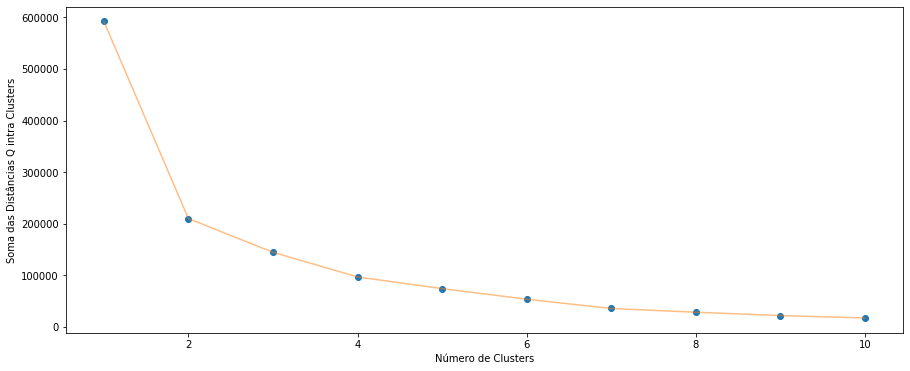

In [53]:
# Escolhendo o melhor K (numero de clusters)
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

In [54]:
# Inicializando e Computando o KMeans com o valor de 7 clusters (testei com 4, mas ficou muito óbvio com os dados disponíveis)
algorithm = (KMeans(n_clusters = 7))
algorithm.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [55]:
# Visualizando os grupos criados e seus centroides
labels2 = algorithm.labels_
labels2

array([3, 3, 1, ..., 5, 5, 5], dtype=int32)

In [56]:
centroids2 = algorithm.cluster_centers_
centroids2

array([[1.        , 2.90239215, 2.        ],
       [3.92151994, 3.7494729 , 1.02010027],
       [1.17267188, 4.        , 1.01295088],
       [4.        , 2.89861579, 1.95540591],
       [1.05924771, 3.        , 1.        ],
       [1.06279458, 1.97404104, 1.00344428],
       [2.12984206, 2.95315046, 1.99521197]])

In [57]:
# Adicionado os clusters nos dados
df_full["clusters"] = algorithm.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
# Visualizando
df_full.head()

,CO_ENTIDADE,NO_ENTIDADE,TP_SITUACAO_FUNCIONAMENTO,CO_REGIAO,CO_MESORREGIAO,CO_MICRORREGIAO,CO_UF,CO_MUNICIPIO,CO_DISTRITO,TP_DEPENDENCIA,TP_LOCALIZACAO,clusters
0,11011726,EMEF EMILIO MARCONDES RIBAS,4,1,1102,11004,11,1100114,110011405,3,2,3
1,11044357,EMEF FAMILIA UNIDA,4,1,1101,11001,11,1100452,110045205,3,2,3
2,11036761,COLEGIO EVOLUCAO,4,1,1102,11003,11,1100023,110002305,4,1,1
3,11018798,EMEF PRES COSTA E SILVA,4,1,1102,11004,11,1100254,110025405,3,2,3
4,11021616,EMEF CASTRO ALVES,4,1,1102,11005,11,1100148,110014805,3,2,3


In [59]:
# Criar grupo para ver as estatísticas
df_group = df_full.drop(["CO_ENTIDADE","NO_ENTIDADE"],axis=1).groupby("clusters")

# Visualizando as estatísticas
df_group.describe()

TP_SITUACAO_FUNCIONAMENTO                           ... TP_LOCALIZACAO               
                             count      mean       std  min  ...            25%  50%  75%  max
clusters                                                     ...                              
0                          54637.0  1.000000  0.000000  1.0  ...            2.0  2.0  2.0  2.0
1                          21343.0  3.921520  0.268932  3.0  ...            1.0  1.0  1.0  2.0
2                          51039.0  1.172672  0.377967  1.0  ...            1.0  1.0  1.0  2.0
3                          40095.0  4.000000  0.000000  4.0  ...            2.0  2.0  2.0  2.0
4                          63513.0  1.059248  0.236090  1.0  ...            1.0  1.0  1.0  1.0
5                          27582.0  1.062795  0.243344  1.0  ...            1.0  1.0  1.0  2.0
6                          30075.0  2.129842  0.336135  2.0  ...            2.0  2.0  2.0  2.0

[7 rows x 72 columns]

# Salvando o Resultado no Excel para análises dos Clusters
A última coluna mostra o Cluster da Escola

In [0]:
# Salvando no Excel
df_full.to_excel('Censo2019.xlsx')

# Resultados e Conclusões

### Resultados
* **Cluster 0** - Basicamente são Escolas Municipais, Rurais em Atividade;
* **Cluster 1** - Basicamente são Escolas Particulares, Urbana e Extinta (No ano do Censo ou em anos anteriores);
* **Cluster 2** - Basicamente são Escolas Particulares, Urbana em Atividade ou Paralisada;
* **Cluster 3** - Basicamente são Escolas Municipais, Rurais e Extinta em anos anteriores;
* **Cluster 4** - Basicamente são Escolas Municipais, Urbanas em Atividade ou Paralisada;
* **Cluster 5** - Basicamente são Escolas Federais e Estaduais em Atividade, Paralisada ou Extinta (ano do Censo);
* **Cluster 6** - Esse tá bem misturado - Escolas Particulares, Municipais, Federais e Estaduais, Rurais e urbanas que estão Paralisadas ou Extinta (ano do Censo).

    ![alt text](https://pessoalex.files.wordpress.com/2020/02/cluster.png)


### Conclusões
A qualidade da base de dados é fundamental para uma boa análise, infelizmente essa base de dados do Censo Escolar 2019, existem diversas variáveis com valores nulos (*Missing Values*), muitas dessas variáveis deixariam o modelo muito melhor, que poderiam nos fornecer melhores *insights*.





